In [6]:
import torch
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.nn.functional import mse_loss, l1_loss
from movqgan import get_movqgan_model

In [7]:
model = get_movqgan_model('67M', pretrained=True, device='mps')

Working with z of shape (1, 4, 32, 32) = 4096 dimensions.


In [8]:
def show_images(batch, return_image=False):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(torch.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    if return_image:
        return Image.fromarray(reshaped.numpy())
    display(Image.fromarray(reshaped.numpy()))

def prepare_image(img):
    """ Transform and normalize PIL Image to tensor. """
    transform = T.Compose([
            T.RandomResizedCrop(512, scale=(1., 1.), ratio=(1., 1.), interpolation=T.InterpolationMode.BICUBIC),
        ])
    pil_image = transform(img)
    arr = np.array(pil_image.convert("RGB"))
    arr = arr.astype(np.float32) / 127.5 - 1
    return torch.from_numpy(np.transpose(arr, [2, 0, 1]))

In [9]:
url = "https://img.freepik.com/free-photo/abstract-autumn-beauty-multi-colored-leaf-vein-pattern-generated-by-ai_188544-9871.jpg"
response = requests.get(url)
img = prepare_image(Image.open(BytesIO(response.content)))

In [10]:
# out = model(img.to('cuda').unsqueeze(0))[0]
# codebook_indices.shape: 4096 = 64x64

with torch.no_grad():
    quant, loss, (perplexity, min_encodings, codebook_indices) = model.encode(img.to('mps').unsqueeze(0))
    out = model.decode(quant)

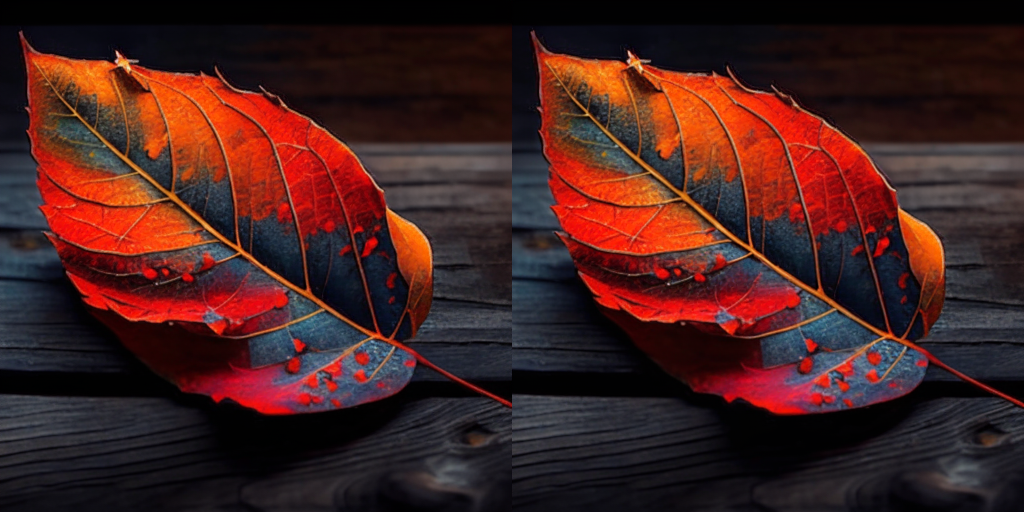

In [11]:
with torch.no_grad():
    reenc_quant, reenc_emb_loss, (reenc_perplexity, reenc_min_encodings, reenc_codebook_indices) = model.encode(out)
    reenc_out = model.decode_code(reenc_codebook_indices.view(1, 64, 64))

show_images(torch.cat((out, reenc_out), dim=0))

In [12]:
print("MSE:", np.round(mse_loss(reenc_out, out).item(), 4))
print("L1 error:", np.round(l1_loss(reenc_out, out).item(), 4))

print("Codebook accuracy:", np.round(np.mean((reenc_codebook_indices == codebook_indices).detach().cpu().numpy()), 4))

MSE: 0.0007
L1 error: 0.0144
Codebook accuracy: 0.7893


torch.Size([4096]) torch.Size([4096])


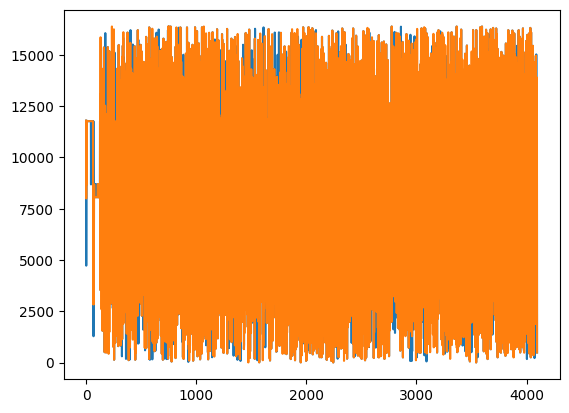

In [13]:
print(codebook_indices.shape, reenc_codebook_indices.shape)

plt.figure()
plt.plot(codebook_indices.detach().cpu())
plt.plot(reenc_codebook_indices.detach().cpu())
plt.show()

In [14]:
def detailed_diff(reference, target):
    from difflib import SequenceMatcher
    sm = SequenceMatcher(a=reference, b=target)
    matching_blocks = sm.get_matching_blocks()

    print("Longest match:", sm.find_longest_match().size)
    
    # Extract the matching subsequences based on the matching blocks
    matching_subsequences = []
    for match in matching_blocks:
        if match.size > 0:  # Skip empty matches
            subsequence = reference[match.a: match.a + match.size]
            matching_subsequences.append(subsequence)

    # for tag, i1, i2, j1, j2 in sm.get_opcodes():
    #     if tag == 'equal':
    #         print(f"Preserved: {reference[i1:i2]}")
    #     elif tag == 'insert':
    #         print(f"Inserted in target: {target[j1:j2]}")
    #     elif tag == 'delete':
    #         print(f"Deleted from reference: {reference[i1:i2]}")
    #     elif tag == 'replace':
    #         print(f"Substituted from {reference[i1:i2]} to {target[j1:j2]}")

    return matching_subsequences

In [15]:
matching_subsequences = detailed_diff(codebook_indices.squeeze().tolist(), reenc_codebook_indices.squeeze().tolist())

# print("Sorted matching subsequence lengths:", sorted([len(seq) for seq in matching_subsequences], reverse=True))
# print("Matching subsequences:")
# print(matching_subsequences)

Longest match: 37


In [16]:
a = codebook_indices.squeeze().tolist()
b = reenc_codebook_indices.squeeze().squeeze().tolist()
print(a)
print(b)

[11796, 4727, 11768, 11768, 11768, 8686, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 8686, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 11768, 8002, 8002, 4727, 2842, 11768, 1287, 8064, 8064, 8064, 8064, 8064, 8686, 8686, 8686, 8064, 8064, 8686, 8686, 8686, 8064, 8686, 8064, 8064, 8064, 8686, 8686, 8686, 8064, 8064, 8064, 8064, 8064, 8064, 8064, 8064, 8686, 8686, 8686, 8064, 8064, 8064, 8686, 8686, 8686, 8686, 8686, 8686, 8686, 8686, 8686, 8064, 8686, 8064, 8686, 8686, 8686, 8064, 8686, 8686, 8686, 8686, 8686, 8686, 8686, 11768, 8002, 3548, 10558, 12295, 8258, 8002, 13086, 3614, 11082, 11796, 7373, 8002, 11082, 7373, 7981, 6819, 3614, 10977, 11796, 12525, 1564, 3614, 3614, 7493, 6579, 3614, 3614, 1564,

MSE: 0.16309
L1 error: 0.27206
Codebook accuracy: 0.00073


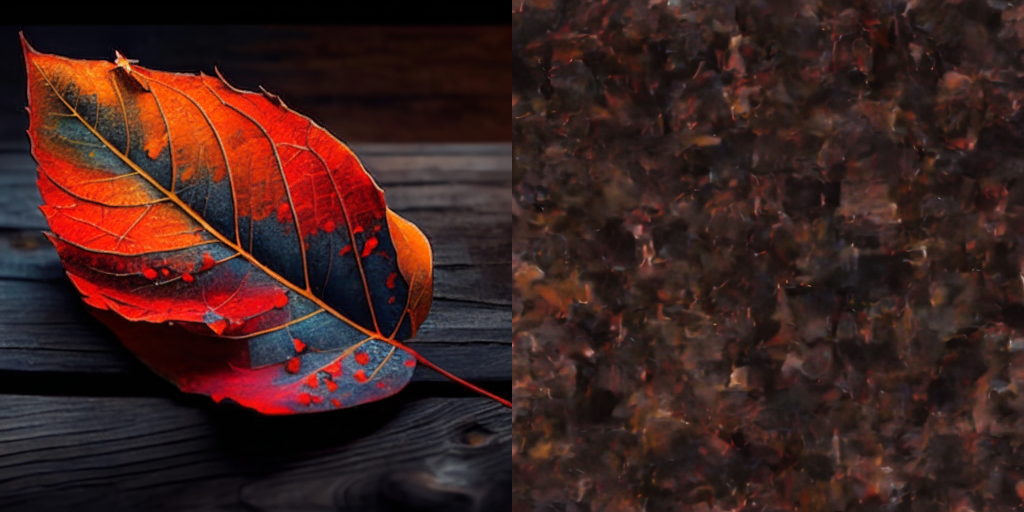

In [17]:
with torch.no_grad():
    # quant, loss, (perplexity, min_encodings, codebook_indices) = model.encode(img.to('cuda').unsqueeze(0))
    # out = model.decode(quant)

    # threshold = -0.5
    # mask = torch.randn_like(codebook_indices, dtype=torch.float) < threshold
    # print("Codes kept:", 1 - mask.float().mean().item())
    # perturbed_indices = (codebook_indices.clone() + 1) % 16384
    # perturbed_indices[mask] = 4567

    x = 0.15
    # Randomly select indices
    num_elements = int(x * 4096)
    selected_indices = torch.randperm(4096)[:num_elements]
    # Shuffle the selected elements
    
    # shuffled_indices = codebook_indices[selected_indices[torch.randperm(num_elements)]]
    perturbed_indices = codebook_indices.clone()
    # perturbed_indices[selected_indices] = shuffled_indices

    shuffled_indices = torch.randperm(4096)
    perturbed_indices = perturbed_indices[shuffled_indices]

    pert_out = model.decode_code(perturbed_indices.view(1, 64, 64))


print("MSE:", np.round(mse_loss(pert_out, out).item(), 5))
print("L1 error:", np.round(l1_loss(pert_out, out).item(), 5))
print("Codebook accuracy:", np.round(np.mean((perturbed_indices == codebook_indices).detach().cpu().numpy()), 5))

show_images(torch.cat((out, pert_out), dim=0))


# transform the 64*64*4 image?

In [18]:
embeddings = model.quantize.embedding.weight

print(embeddings.shape)

embeddings_np = embeddings.detach().cpu().numpy()

torch.Size([16384, 4])


In [20]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

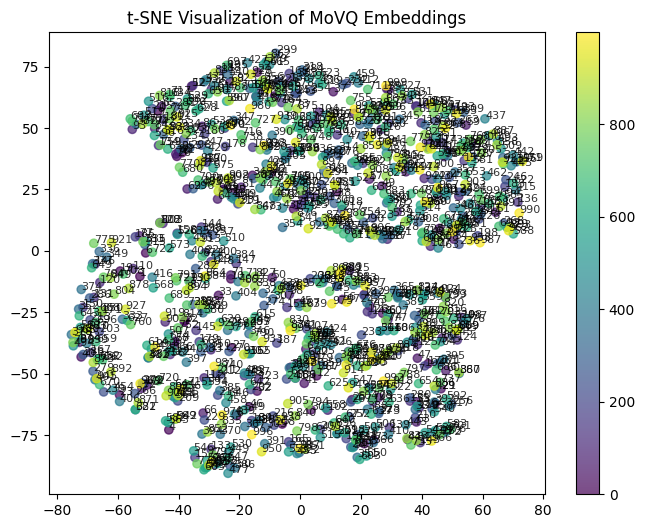

In [21]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)[:1000]

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(embeddings_2d.shape[0]), cmap="viridis", alpha=0.7)
plt.title('t-SNE Visualization of MoVQ Embeddings')
plt.colorbar(scatter)

for i, (x, y) in enumerate(embeddings_2d):
    plt.text(x, y, str(i), fontsize=8, alpha=0.8)

plt.show()


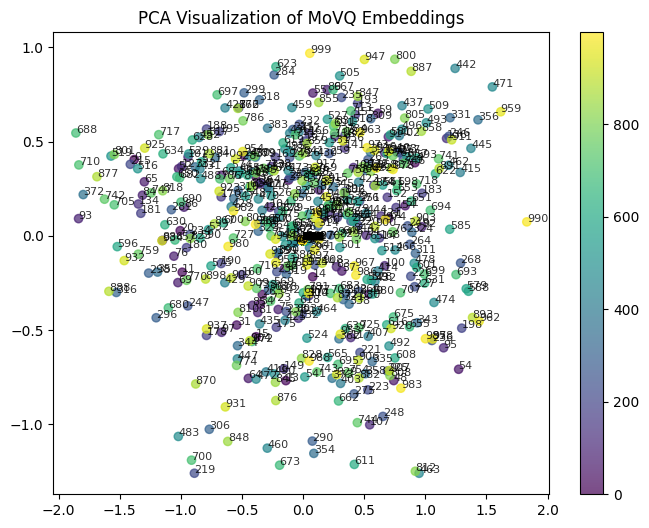

In [22]:
# Apply PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)[:1000]

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(embeddings_2d.shape[0]), cmap="viridis", alpha=0.7)
plt.title('PCA Visualization of MoVQ Embeddings')
plt.colorbar(scatter)

for i, (x, y) in enumerate(embeddings_2d):
    plt.text(x, y, str(i), fontsize=8, alpha=0.8)

plt.show()